In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys  
from pathlib import Path

#Archivos propios
import src.models as models
import src.preprocessing as pre
import src.metrics as metrics
import src.balancing as bal

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [2]:
path_imb_dev = "./I302_ML_TP02_Ejercicio 1/Ejercicio 1/data/raw/cell_diagnosis_imbalanced_dev.csv"
path_imb_test = "./I302_ML_TP02_Ejercicio 1/Ejercicio 1/data/raw/cell_diagnosis_imbalanced_test.csv"
path_bal_dev = "./I302_ML_TP02_Ejercicio 1/Ejercicio 1/data/raw/cell_diagnosis_balanced_dev.csv"
path_bal_test = "./I302_ML_TP02_Ejercicio 1/Ejercicio 1/data/raw/cell_diagnosis_balanced_test.csv"

# Cargo datasets
imb_dev = pd.read_csv(path_imb_dev)
imb_test = pd.read_csv(path_imb_test)
bal_dev = pd.read_csv(path_bal_dev)
bal_test = pd.read_csv(path_bal_test)

ANALISIS DE LOS DATOS

In [3]:
# Veo las primeras filas y shape de cada uno
print("Imbalanced Dev:", imb_dev.shape)
print("Imbalanced Test:", imb_test.shape)
print("Balanced Dev:", bal_dev.shape)
print("Balanced Test:", bal_test.shape)

Imbalanced Dev: (1218, 15)
Imbalanced Test: (136, 15)
Balanced Dev: (1663, 15)
Balanced Test: (185, 15)


In [4]:
# Primer vistazo de los datos y la cantidad de datos faltantes
print(bal_dev.head())
print(bal_dev.info())


    CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  CellAdhesion  MitosisRate  NuclearMembrane  GrowthFactor  OxygenSaturation  Vascularization  InflammationMarkers  Diagnosis    CellType GeneticMutation
0  63.423148   0.500594        1.473261         23.300222            NaN      0.477657     3.434832         2.492852    -10.000000         78.625935         5.727217            41.158399        0.0    Epthlial           Absnt
1  72.906362   0.474808        1.361360         21.336137      29.856233      0.481035     2.702433         2.281137     63.084699               NaN         5.319552                  NaN        1.0    Epthlial          Presnt
2  70.711969   0.481701             NaN         21.521406      30.582427      0.472651     2.786606         2.318029     61.347022               NaN              NaN                  NaN        1.0         ???           Absnt
3  73.210206        NaN        1.427612         22.437077      29.887970      0.439511     2.998

In [5]:
#Defino target
TARGET = "Diagnosis"

# Divido el set de dev
train_df, val_df = pre.split_train_test(bal_dev)

# Copio el dataset de test para no modificar los originales
test_df = bal_test.copy()

# Identifico columnas numéricas y categóricas
num_cols, cat_cols = pre.infer_cols(train_df, target=TARGET)


In [6]:
# Elimino filas con datos faltantes en la columna "Diagnosis" de todos los datasets
train_df = train_df.dropna(subset=[TARGET])
val_df = val_df.dropna(subset=[TARGET])
test_df = test_df.dropna(subset=[TARGET])

# Manejo de Outliers en columnas numéricas
theoretical_bounds = {"CellAdhesion": (0.0, 1.0),}


# Calculo limites inferiores/superiores por columna para detectar/recortar outliers.
ranges_train = train_df[num_cols].describe().T[["min","max","mean","std"]]
bounds = pre.build_outlier_bounds(train_df, num_cols, theoretical_bounds=theoretical_bounds, use_ranges_df=ranges_train, iqr_k=1.5)

# Recorto valores fuera de los bounds, elimino filas que no cumplen al menos una regla, seteo NaNs los que no esten en el rango para luego imputar
train_df_ol , report_train = (pre.handle_outliers(train_df, bounds, action="clip"))
val_df_ol  , report_test= (pre.handle_outliers(val_df,  bounds, action="clip"))
test_df_ol , report_val = (pre.handle_outliers(test_df, bounds, action="clip"))

# Completo los NaNs de las columnas categericas con la moda de cada columna
train_df_imp = pre.add_missing_values_mode(train_df_ol, cat_cols)
val_df_imp  = pre.add_missing_values_mode(val_df_ol,  cat_cols)
test_df_imp = pre.add_missing_values_mode(test_df_ol, cat_cols)

# Competo los NaNs de las columnas numericas usando KNN    
train_df = pre.handle_missing_values(train_df_imp, num_cols, method='knn')
val_df = pre.handle_missing_values(val_df_imp, num_cols, method='knn')
test_df = pre.handle_missing_values(test_df_imp, num_cols, method='knn')

# One-Hot Encoding de las variables categóricas "CellType" y "GeneticMutation"
train_df = pd.get_dummies(train_df, columns=["CellType", "GeneticMutation"], drop_first=True)
val_df = pd.get_dummies(val_df, columns=["CellType", "GeneticMutation"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["CellType", "GeneticMutation"], drop_first=True)

# Normalizo usando mu y sigma del set de test para evitar data leakage
train_df, val_df, mu , sigma = pre.normalize(train_df, val_df, target_name=TARGET)

# Normalizo el set de test usando mu y sigma del set de train para evitar data leakage
test_df = pre.normalize_test(test_df, mu, sigma, target_name=TARGET)


print(train_df.info())





<class 'pandas.core.frame.DataFrame'>
Index: 1330 entries, 1448 to 1386
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CellSize                1330 non-null   float64
 1   CellShape               1330 non-null   float64
 2   NucleusDensity          1330 non-null   float64
 3   ChromatinTexture        1330 non-null   float64
 4   CytoplasmSize           1330 non-null   float64
 5   CellAdhesion            1330 non-null   float64
 6   MitosisRate             1330 non-null   float64
 7   NuclearMembrane         1330 non-null   float64
 8   GrowthFactor            1330 non-null   float64
 9   OxygenSaturation        1330 non-null   float64
 10  Vascularization         1330 non-null   float64
 11  InflammationMarkers     1330 non-null   float64
 12  Diagnosis               1330 non-null   float64
 13  CellType_Epthlial       1330 non-null   bool   
 14  CellType_Mesnchymal     1330 non-null   bo

c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lucas\App

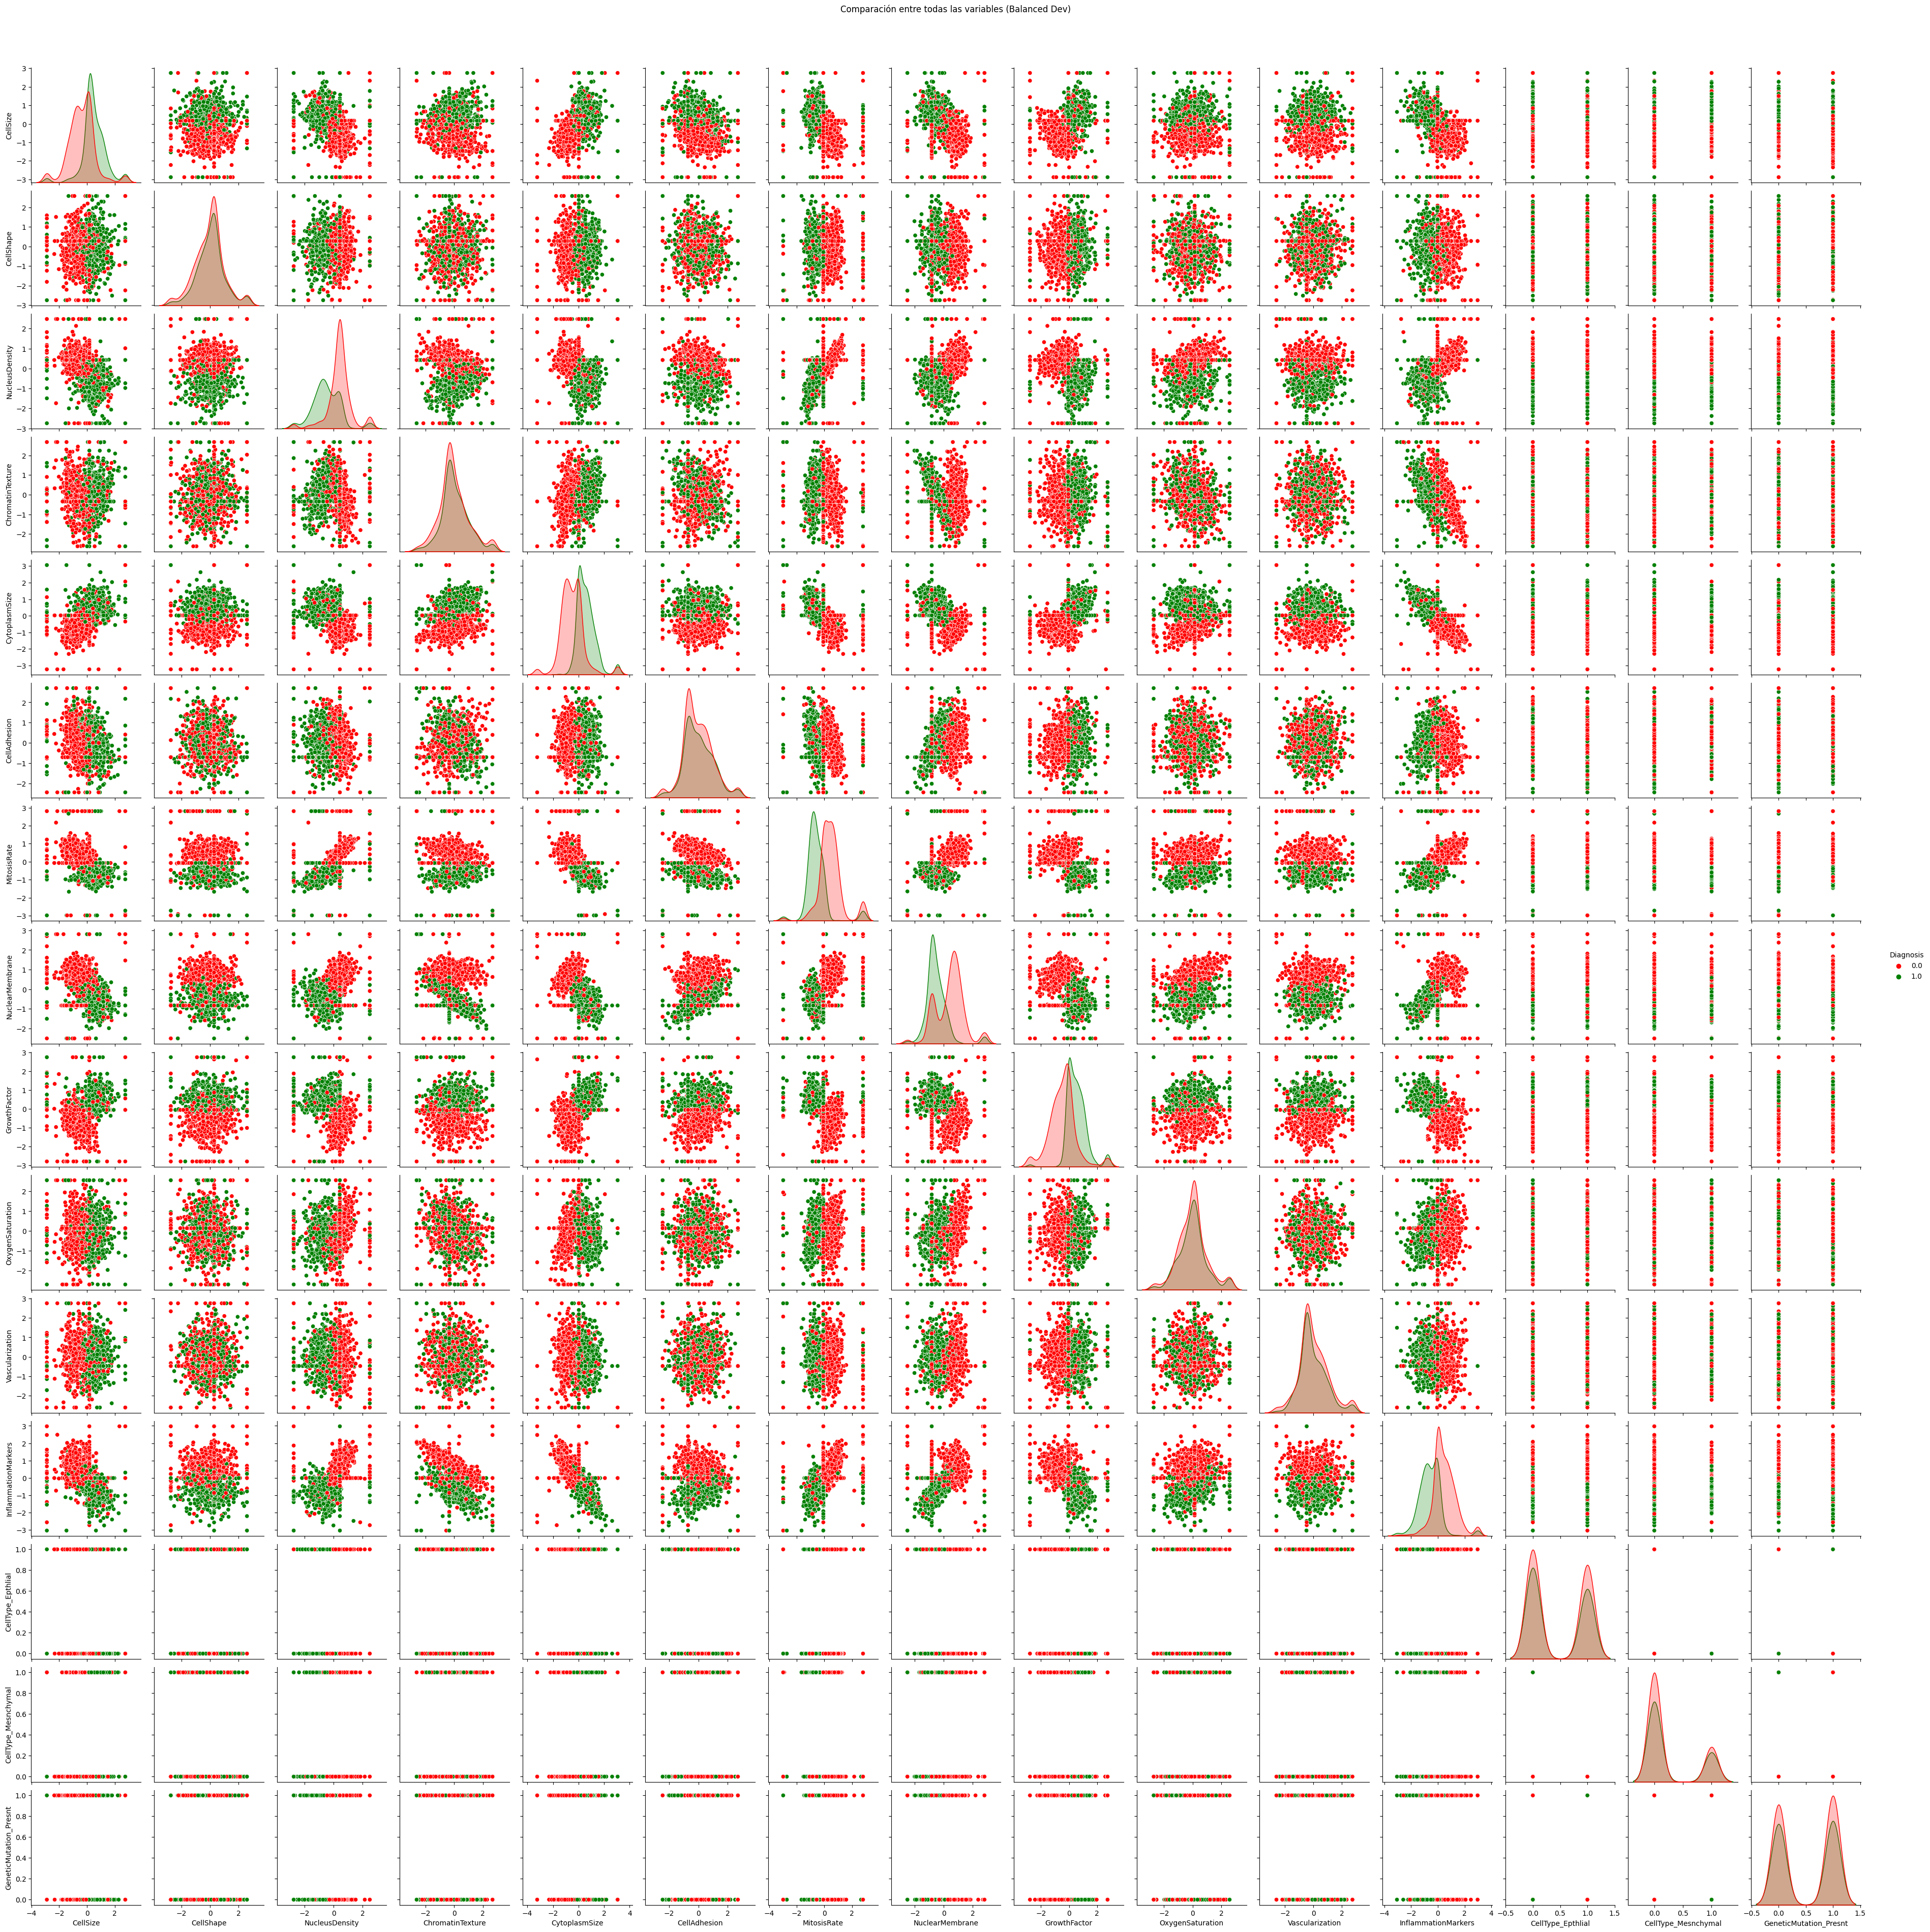

In [7]:
#scatter plots de las columnas para comparar todas con todas, coloreando por Diagnosis
palette = {0: "red", 1: "green"}
sns.pairplot(train_df, hue="Diagnosis", palette=palette)
plt.suptitle('Comparación entre todas las variables (Balanced Dev)', y=1.02)
plt.show()

IMPLEMENTACION DEL MODELO DE REGRESION LOGISTICA CON REGULARIZACION L2

c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:43: RuntimeWarning: overflow encountered in matmul
  z = X @ self.weights + self.bias
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:54: RuntimeWarning: overflow encountered in multiply
  self.weights = (1.0 - lr * lam) * self.weights - lr * grad_w
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:43: RuntimeWarning: invalid value encountered in matmul
  z = X @ self.weights + self.bias


Best lambda: 0.7847599703514607, Best F1-score (weighted): 0.876200


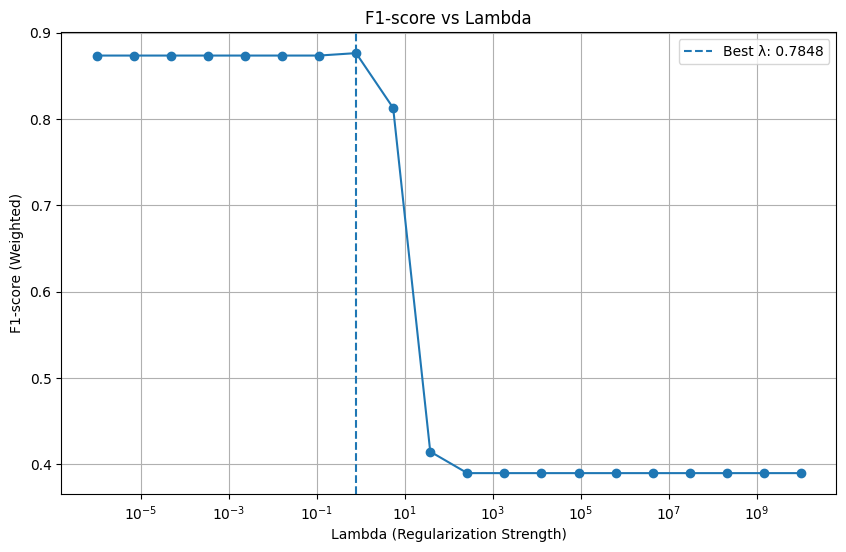

In [8]:

def _ensure_float_matrix(X):
    # coerciona a float64 sin romper si viene de pandas
    return np.asarray(X, dtype=np.float64)

def _ensure_labels_array(y):
    # deja Y como array 
    return np.asarray(y)

def _weighted_f1_from_dict(f1_dict, y_true, labels):
    # weighted por soporte real de y_true
    return float(sum(f1_dict[label] * np.sum(y_true == label) for label in labels) / len(y_true))

X_train = _ensure_float_matrix(train_df.drop(columns=["Diagnosis"]).values)
y_train = _ensure_labels_array(train_df["Diagnosis"].values)
X_val   = _ensure_float_matrix(val_df.drop(columns=["Diagnosis"]).values)
y_val   = _ensure_labels_array(val_df["Diagnosis"].values)

labels = np.unique(y_train)
n_classes = len(labels)

# Hago el barrido de lambdas para encontrar el mejor lambda
lambdas = np.logspace(-6, 10, 20)
best_lambda = None
best_f1 = -1.0
best_model = None       
f1_scores = []

LEARNING_RATE = 0.001
N_ITER = 1000

for L2 in lambdas:
        # Etreno modelos con los distintos Lambdas
        model = models.LogisticRegressionL2(L2=L2, learning_rate=LEARNING_RATE, n_iter=N_ITER)
        model.fit(X_train, (y_train == labels[1]).astype(float))  
        y_val_pred = model.predict(X_val)            
        y_val_pred_labels = np.where(y_val_pred == 1, labels[1], labels[0])
        f1_dict = metrics.f1_score(y_val, y_val_pred_labels, labels)
        f1_w = _weighted_f1_from_dict(f1_dict, y_val, labels)
        f1_scores.append(f1_w)
        if f1_w > best_f1:
            best_f1 = f1_w
            best_lambda = L2
            best_model = model

print(f"Best lambda: {best_lambda}, Best F1-score (weighted): {best_f1:.6f}")

# Gráfico F1-score vs lambda
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, f1_scores, marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('F1-score (Weighted)')
plt.title('F1-score vs Lambda')
plt.grid(True)
plt.axvline(best_lambda, linestyle='--', label=f'Best λ: {best_lambda:.4g}')
plt.legend()
plt.show()


REPORTE DE METRICAS

Confusion Matrix:
 [[169  14]
 [ 27 123]]


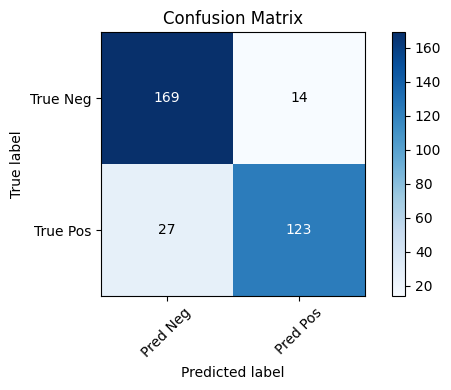

In [9]:
# Me guardo el mejor modelo entrenado con el mejor lambda
best_model = models.LogisticRegressionL2(L2=best_lambda, learning_rate=LEARNING_RATE, n_iter=N_ITER)
best_model.fit(X_train, (y_train == labels[1]).astype(float))  # map a {0,1} respecto a la clase positiva

# Reporto la matriz de confusión y métricas finales en el mejor modelo
# Matriz de confusión
y_val_pred = best_model.predict(X_val)                         # 0/1
# Volvemos a etiquetas originales para métricas
y_val_pred_labels = np.where(y_val_pred == 1, labels[1], labels[0])
cm = metrics.confusion_matrix(y_val, y_val_pred_labels, labels)
print("Confusion Matrix:\n", cm)

cm = pd.DataFrame(cm, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos'])   
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cm.columns))
plt.xticks(tick_marks, cm.columns, rotation=45)
plt.yticks(tick_marks, cm.index)
thresh = cm.values.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm.iloc[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm.iloc[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [10]:
# Reporto Accuracy, Precision, Recall, F1-score

f1_dict = metrics.f1_score(y_val, y_val_pred_labels, labels)
precision_dict = metrics.precision(y_val, y_val_pred_labels, labels)
recall_dict = metrics.recall(y_val, y_val_pred_labels, labels)
accuracy = metrics.accuracy(y_val, y_val_pred_labels)

print(f"Accuracy: {accuracy:.6f}")
print("Precision per class:", precision_dict)
print("Recall per class:", recall_dict)
print("F1-score per class:", f1_dict)
print(f"Weighted F1-score: {_weighted_f1_from_dict(f1_dict, y_val, labels):.6f}")


Accuracy: 0.876877
Precision per class: {0.0: 0.8622448979591837, 1.0: 0.8978102189781022}
Recall per class: {0.0: 0.9234972677595629, 1.0: 0.82}
F1-score per class: {0.0: 0.8918205804749341, 1.0: 0.8571428571428571}
Weighted F1-score: 0.876200


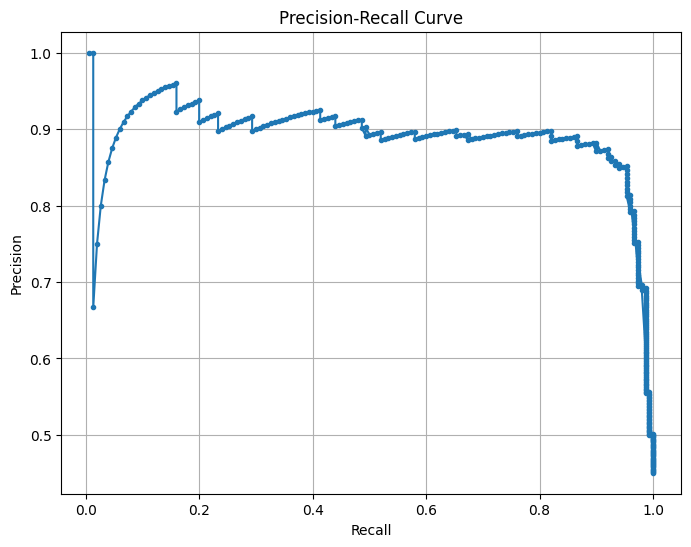

In [11]:
# Reporto la curva Precision-Recall (PR) 

# Obtener probabilidades del modelo para la clase positiva
y_val_proba = best_model.predict_proba(X_val)

# Calcular la curva PR
precisions, recalls = metrics.pr_curve_ovr(y_val, y_val_proba, positive_label=labels[1])

# Graficar la curva PR
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

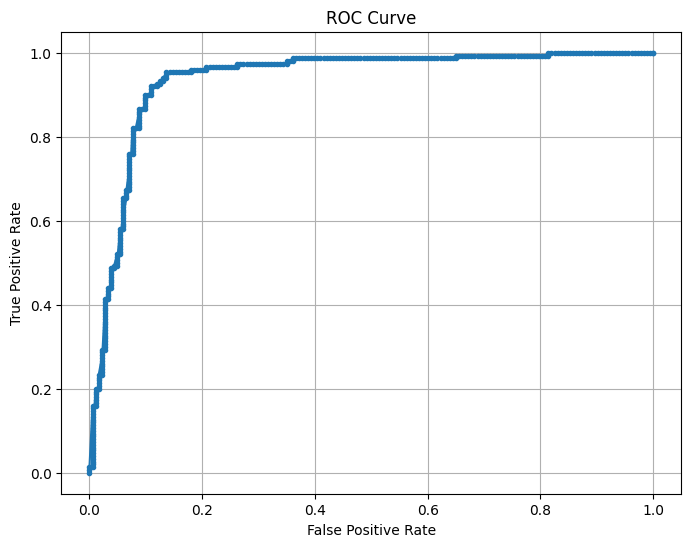

In [12]:
# Reporto la curva ROC

def predict_proba(self, X):
    self._check_fitted()
    X = np.asarray(X, dtype=np.float64)
    z = X @ self.weights + self.bias
    return self.sigmoid(z)

def predict(self, X, threshold=0.5):
    proba = self.predict_proba(X)
    return (proba >= threshold).astype(int)

# Obtener probabilidades del modelo para la clase positiva
y_val_proba = best_model.predict_proba(X_val)

# Reporto Curva ROC
fpr, tpr= metrics.roc_curve_ovr(y_val, y_val_proba, positive_label=labels[1])

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

In [13]:
# Reporto la curva AUC-ROC usando auc_roc_ovr
auc_roc = metrics.auc_roc_ovr(y_val, y_val_proba, positive_label=labels[1])
print(f"AUC-ROC: {auc_roc:.6f}")

# Reporto la curva AUC-PR usando auc_pr_ovr
auc_pr = metrics.auc_pr_ovr(y_val, y_val_proba, positive_label=labels[1])
print(f"AUC-PR: {auc_pr:.6f}")


AUC-ROC: 0.936594
AUC-PR: 0.883963


EVALUACION DEL MODELO SOBRE EL SET DE TEST

Confusion Matrix:
 [[94  8]
 [12 71]]


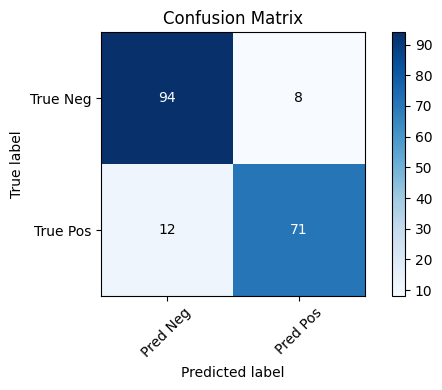

In [14]:
# Reporto la matriz de confusión y métricas finales en el mejor modelo
# Matriz de confusión

X_test = _ensure_float_matrix(test_df.drop(columns=["Diagnosis"]).values)
y_test = _ensure_labels_array(test_df["Diagnosis"].values)

y_test_pred = best_model.predict(X_test)    

# Volvemos a etiquetas originales para métricas
y_test_pred_labels = np.where(y_test_pred == 1, labels[1], labels[0])
cm = metrics.confusion_matrix(y_test, y_test_pred_labels, labels)

cm = metrics.confusion_matrix(y_test, y_test_pred_labels, labels)
print("Confusion Matrix:\n", cm)

cm = pd.DataFrame(cm, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos'])   
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cm.columns))
plt.xticks(tick_marks, cm.columns, rotation=45)
plt.yticks(tick_marks, cm.index)
thresh = cm.values.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm.iloc[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm.iloc[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [15]:
# Reporto Accuracy, Precision, Recall, F1-score

f1_dict = metrics.f1_score(y_test, y_test_pred_labels, labels)
precision_dict = metrics.precision(y_test, y_test_pred_labels, labels)
recall_dict = metrics.recall(y_test, y_test_pred_labels, labels)
accuracy = metrics.accuracy(y_test, y_test_pred_labels)

print(f"Accuracy: {accuracy:.6f}")
print("Precision per class:", precision_dict)
print("Recall per class:", recall_dict)
print("F1-score per class:", f1_dict)
print(f"Weighted F1-score: {_weighted_f1_from_dict(f1_dict, y_val, labels):.6f}")


Accuracy: 0.891892
Precision per class: {0.0: 0.8867924528301887, 1.0: 0.8987341772151899}
Recall per class: {0.0: 0.9215686274509803, 1.0: 0.8554216867469879}
F1-score per class: {0.0: 0.9038461538461539, 1.0: 0.8765432098765433}
Weighted F1-score: 0.891548


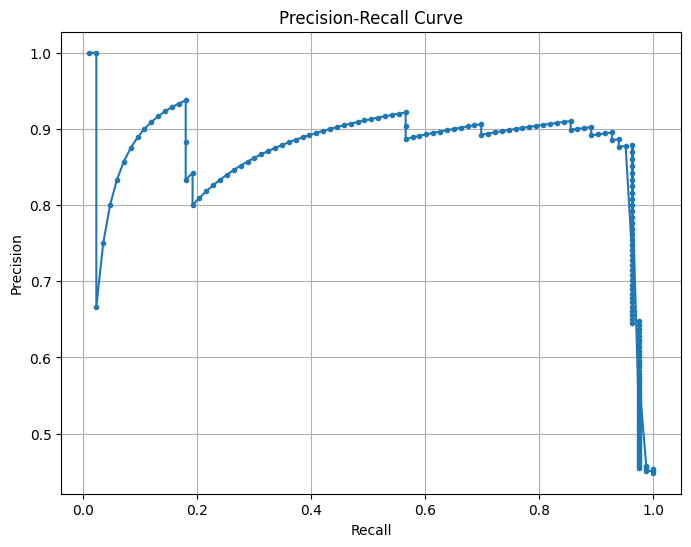

In [16]:
# Reporto la curva Precision-Recall (PR) 
# Obtener probabilidades del modelo para la clase positiva
y_test_proba = best_model.predict_proba(X_test)

# Calcular la curva PR
precisions, recalls = metrics.pr_curve_ovr(y_test, y_test_proba, positive_label=labels[1])

# Graficar la curva PR
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

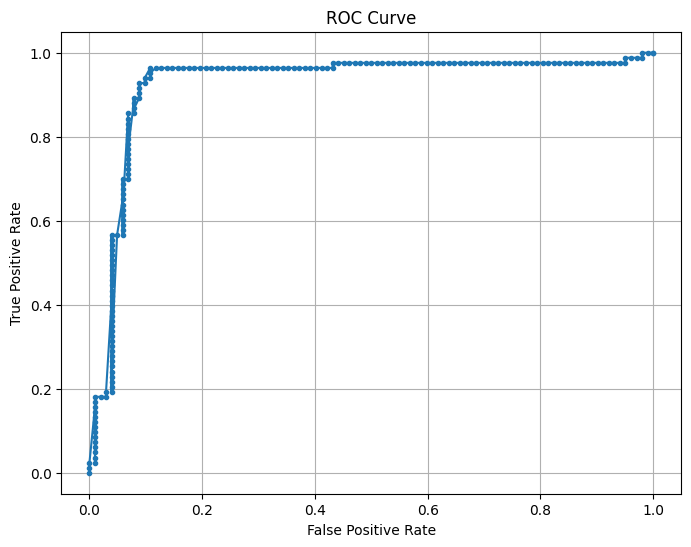

In [17]:
# Obtener probabilidades del modelo para la clase positiva
y_test_proba = best_model.predict_proba(X_test)

# Reporto Curva ROC
fpr, tpr= metrics.roc_curve_ovr(y_test, y_test_proba, positive_label=labels[1])

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

In [18]:
# Reporto la curva AUC-ROC usando auc_roc_ovr
auc_roc = metrics.auc_roc_ovr(y_test, y_test_proba, positive_label=labels[1])
print(f"AUC-ROC: {auc_roc:.6f}")

# Reporto la curva AUC-PR usando auc_pr_ovr
auc_pr = metrics.auc_pr_ovr(y_test, y_test_proba, positive_label=labels[1])
print(f"AUC-PR: {auc_pr:.6f}")


AUC-ROC: 0.926648
AUC-PR: 0.862092


Pre procesamiento de los datos desvalanceados

In [19]:
train_df, val_df = pre.split_train_test(imb_dev)
# Copio el dataset de test para no modificar los originales
test_df = imb_test.copy()

# Elimino filas con datos faltantes en la columna "Diagnosis" de todos los datasets
train_df = train_df.dropna(subset=[TARGET])
val_df = val_df.dropna(subset=[TARGET])
test_df = test_df.dropna(subset=[TARGET])

# Manejo de Outliers en columnas numéricas
theoretical_bounds = {"CellAdhesion": (0.0, 1.0),}

ranges_train = train_df[num_cols].describe().T[["min","max","mean","std"]]
bounds = pre.build_outlier_bounds(train_df, num_cols, theoretical_bounds=theoretical_bounds, use_ranges_df=ranges_train, iqr_k=1.5)

train_df_ol , report_train = (pre.handle_outliers(train_df, bounds, action="clip"))
val_df_ol  , report_test= (pre.handle_outliers(val_df,  bounds, action="clip"))
test_df_ol , report_val = (pre.handle_outliers(test_df, bounds, action="clip"))

# Completo los NaNs de las columnas categoricas con la moda de cada columna
train_df_imp = pre.add_missing_values_mode(train_df_ol, cat_cols)
val_df_imp  = pre.add_missing_values_mode(val_df_ol,  cat_cols)
test_df_imp = pre.add_missing_values_mode(test_df_ol, cat_cols)

# Completo los NaNs de las columnas numericas usando KNN
train_df = pre.handle_missing_values(train_df_imp, num_cols, method='knn')
val_df = pre.handle_missing_values(val_df_imp, num_cols, method='knn')
test_df = pre.handle_missing_values(test_df_imp, num_cols, method='knn')

# One-Hot Encoding de las variables categoricas "CellType" y "GeneticMutation"
train_df = pd.get_dummies(train_df, columns=["CellType", "GeneticMutation"], drop_first=True)
val_df = pd.get_dummies(val_df, columns=["CellType", "GeneticMutation"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["CellType", "GeneticMutation"], drop_first=True)

# Normalizo usando mu y sigma del set de test para evitar data leakage
train_df, val_df, mu , sigma = pre.normalize(train_df, val_df, target_name=TARGET)

# Normalizo el set de test usando mu y sigma del set de train para evitar data leakage
test_df = pre.normalize_test(test_df, mu, sigma, target_name=TARGET)

print(train_df.info())





<class 'pandas.core.frame.DataFrame'>
Index: 974 entries, 541 to 800
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CellSize                974 non-null    float64
 1   CellShape               974 non-null    float64
 2   NucleusDensity          974 non-null    float64
 3   ChromatinTexture        974 non-null    float64
 4   CytoplasmSize           974 non-null    float64
 5   CellAdhesion            974 non-null    float64
 6   MitosisRate             974 non-null    float64
 7   NuclearMembrane         974 non-null    float64
 8   GrowthFactor            974 non-null    float64
 9   OxygenSaturation        974 non-null    float64
 10  Vascularization         974 non-null    float64
 11  InflammationMarkers     974 non-null    float64
 12  Diagnosis               974 non-null    float64
 13  CellType_Epthlial       974 non-null    bool   
 14  CellType_Mesnchymal     974 non-null    bool 

APLICACION DE LOS DISTINTOS METODOS DE REBALANCEO

c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:43: RuntimeWarning: overflow encountered in matmul
  z = X @ self.weights + self.bias
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:43: RuntimeWarning: invalid value encountered in matmul
  z = X @ self.weights + self.bias
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:54: RuntimeWarning: overflow encountered in multiply
  self.weights = (1.0 - lr * lam) * self.weights - lr * grad_w
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\model

                   Modelo    lambda  Accuracy  Precision_pos  Recall_pos    F1_pos   AUC_ROC    AUC_PR
1           undersampling  1.623777  0.905738       0.736111    0.929825  0.821705  0.947838  0.757677
2  oversampling_duplicate  0.233572  0.901639       0.726027    0.929825  0.815385  0.953560  0.771149
3                   smote  1.623777  0.901639       0.726027    0.929825  0.815385  0.947884  0.763021
0            no_rebalance  0.000100  0.913934       0.821429    0.807018  0.814159  0.954029  0.759550
4        cost_reweighting  4.281332  0.901639       0.732394    0.912281  0.812500  0.945304  0.760560


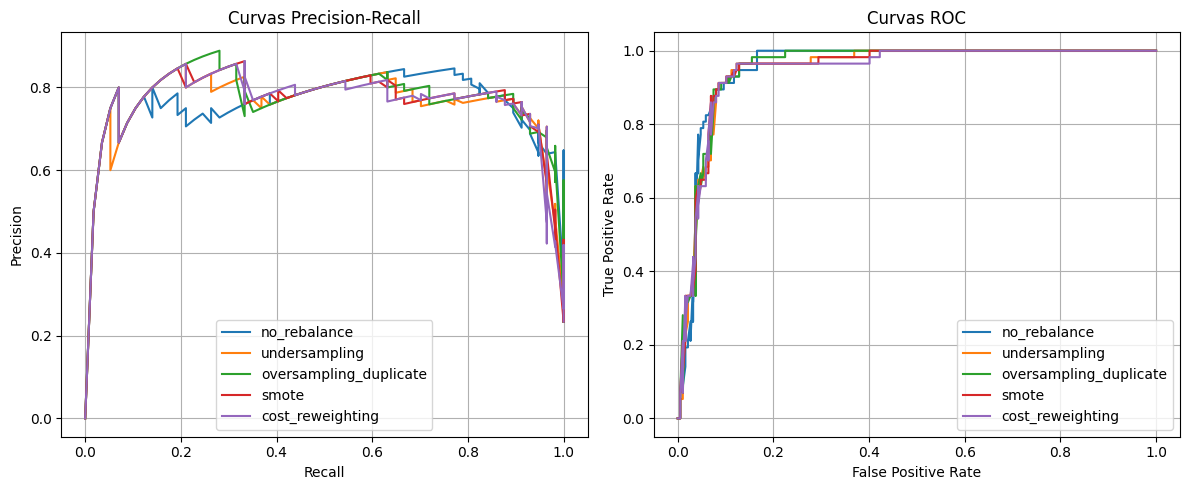

In [20]:

# Métodos de rebalanceo (solo en TRAIN)
methods = {
    "no_rebalance": lambda df: bal.no_rebalance(df, TARGET),
    "undersampling": lambda df: bal.undersample_majority(df, TARGET, random_state=42),
    "oversampling_duplicate": lambda df: bal.oversample_duplicate(df, TARGET, random_state=42),
    "smote": lambda df: bal.smote_oversample(df, TARGET, numeric_cols=num_cols, k=5, random_state=42),
    "cost_reweighting":lambda df: print("NADA")
}

labels = np.unique(train_df[TARGET].values)
neg_label, pos_label = labels[0], labels[1]

def to_xy(df):
    X = df.drop(columns=[TARGET]).values.astype(np.float64)
    y = df[TARGET].values
    return X, y

X_val, y_val = to_xy(val_df)

results = []
pr_curves = {}
roc_curves = {}
models_dict = {}

lambdas = np.logspace(-4, 4, 20)

# Aplico los distintos metodos
for name, fn in methods.items():
    # preparar TRAIN según el método (excepto cost-reweighting, que no modifica df)
    train_bal = fn(train_df) if name != "cost_reweighting" else train_df.copy()
    X_train, y_train = to_xy(train_bal)
    y_train_bin = (y_train == pos_label).astype(float)

    # cost re-weighting: pesos
    sample_weight = None
    if name == "cost_reweighting":
        sample_weight, infoW = bal.cost_reweighting_sample_weights(y_train)

    # hago barrido de lambdas con F1-weighted y me quedo con el mejor modelo
    best_f1, best_lam = -1.0, None
    best_model = None
    for L2 in lambdas:
        m = models.LogisticRegressionL2(L2=L2, learning_rate=0.01, n_iter=1000)
        m.fit(X_train, y_train_bin, sample_weight=sample_weight)
        proba_val = m.predict_proba(X_val)
        y_val_pred_bin = (proba_val >= 0.5).astype(int)
        y_val_pred = np.where(y_val_pred_bin == 1, pos_label, neg_label)
        f1_dict = metrics.f1_score(y_val, y_val_pred, labels)
        f1_w = float(np.sum([f1_dict[lbl]*(y_val==lbl).sum() for lbl in labels]) / len(y_val))
        if f1_w > best_f1:
            best_f1, best_lam, best_model = f1_w, L2, m
    models_dict[name] = best_model

    # Metricas finales
    proba_val = best_model.predict_proba(X_val)
    y_val_pred_bin = (proba_val >= 0.5).astype(int)
    y_val_pred = np.where(y_val_pred_bin == 1, pos_label, neg_label)

    cm = metrics.confusion_matrix(y_val, y_val_pred, labels)
    acc = metrics.accuracy(y_val, y_val_pred)
    prec = metrics.precision(y_val, y_val_pred, labels)
    rec  = metrics.recall(y_val, y_val_pred, labels)
    f1d  = metrics.f1_score(y_val, y_val_pred, labels)

    # Curva PR y ROC con la proba de la clase positiva:
    P_points, R_points = metrics.pr_curve_ovr(y_val, proba_val, positive_label=pos_label)
    F_points, T_points = metrics.roc_curve_ovr(y_val, proba_val, positive_label=pos_label)
    auc_pr  = metrics.auc_pr_ovr(y_val, proba_val, positive_label=pos_label)
    auc_roc = metrics.auc_roc_ovr(y_val, proba_val, positive_label=pos_label)

    results.append({
        "Modelo": name,
        "lambda": best_lam,
        "Accuracy": acc,
        "Precision_pos": prec[pos_label],
        "Recall_pos": rec[pos_label],
        "F1_pos": f1d[pos_label],
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
    })

# Tabla comparativa 
report_df = pd.DataFrame(results)
print(report_df.sort_values("F1_pos", ascending=False))

# Grafico todas las curvas PR y ROC en un solo gráfico

plt.figure(figsize=(12, 5))

# Curvas PR
plt.subplot(1, 2, 1)
for name, fn in methods.items():
    train_bal = fn(train_df) if name != "cost_reweighting" else train_df.copy()
    X_train, y_train = to_xy(train_bal)
    y_train_bin = (y_train == pos_label).astype(float)
    sample_weight = None
    if name == "cost_reweighting":
        sample_weight, _ = bal.cost_reweighting_sample_weights(y_train)

    # Entreno con el mejor lambda de cada modelo
    m = models.LogisticRegressionL2(L2=report_df.loc[report_df["Modelo"] == name, "lambda"].values[0], learning_rate=0.01, n_iter=1000)
    m.fit(X_train, y_train_bin, sample_weight=sample_weight)
    proba_val = m.predict_proba(X_val)
    P_points, R_points = metrics.pr_curve_ovr(y_val, proba_val, positive_label=pos_label)
    plt.plot(R_points, P_points, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.grid(True)

# Curvas ROC
plt.subplot(1, 2, 2)
for name, fn in methods.items():
    train_bal = fn(train_df) if name != "cost_reweighting" else train_df.copy()
    X_train, y_train = to_xy(train_bal)
    y_train_bin = (y_train == pos_label).astype(float)
    sample_weight = None
    if name == "cost_reweighting":
        sample_weight, _ = bal.cost_reweighting_sample_weights(y_train)
    m = models.LogisticRegressionL2(L2=report_df.loc[report_df["Modelo"] == name, "lambda"].values[0], learning_rate=0.01, n_iter=1000)
    m.fit(X_train, y_train_bin, sample_weight=sample_weight)
    proba_val = m.predict_proba(X_val)
    F_points, T_points = metrics.roc_curve_ovr(y_val, proba_val, positive_label=pos_label)
    plt.plot(F_points, T_points, label=name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


EVALUACION DE LOS MODELOS EN TEST

Final Test Metrics:
                         Accuracy  Precision    Recall  F1 Score   AUC-ROC    AUC-PR
Model                                                                              
no_rebalance            0.875000   0.793103  0.676471  0.730159  0.950980  0.746584
undersampling           0.904412   0.769231  0.882353  0.821918  0.940744  0.727002
oversampling_duplicate  0.904412   0.769231  0.882353  0.821918  0.945646  0.733878
smote                   0.904412   0.769231  0.882353  0.821918  0.942186  0.713843
cost_reweighting        0.904412   0.769231  0.882353  0.821918  0.939879  0.718760


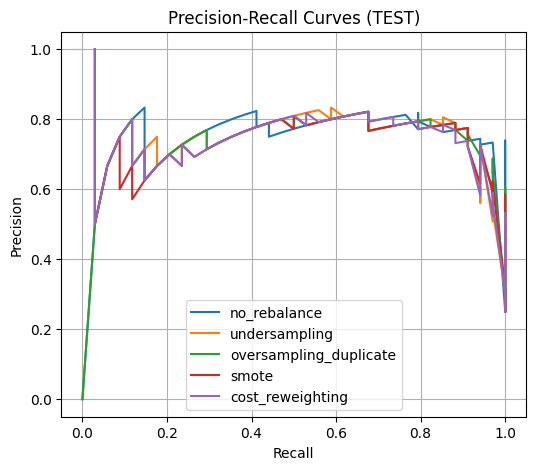

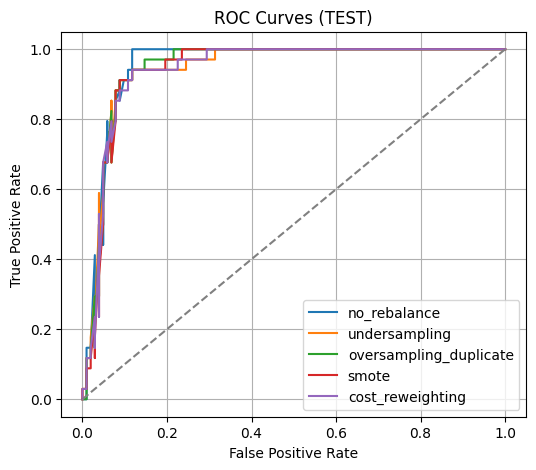

In [21]:
def compute_binary_report(y_true, y_pred_labels, y_scores_pos, labels):
    pos_label = labels[1]

    acc = metrics.accuracy(y_true, y_pred_labels)
    prec_d = metrics.precision(y_true, y_pred_labels, labels)
    rec_d  = metrics.recall(y_true, y_pred_labels, labels)
    f1_d   = metrics.f1_score(y_true, y_pred_labels, labels)

    prec = float(prec_d[pos_label])
    rec  = float(rec_d[pos_label])
    f1   = float(f1_d[pos_label])

    auc_roc = float(metrics.auc_roc_ovr(y_true, y_scores_pos, positive_label=pos_label))
    auc_pr  = float(metrics.auc_pr_ovr(y_true, y_scores_pos, positive_label=pos_label))

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC-ROC": auc_roc,
        "AUC-PR": auc_pr,
    }

# Evaluación de todos los modelos en TEST

y_test = _ensure_labels_array(test_df[TARGET].values)
X_test = _ensure_float_matrix(test_df.drop(columns=[TARGET]).values)

labels = np.unique(y_test)
neg_label, pos_label = labels[0], labels[1]

results = []
pr_curves = {}
roc_curves = {}

for name, model in models_dict.items():
    # Predicciones en TEST
    proba_test = model.predict_proba(X_test)
    y_test_pred_bin = (proba_test >= 0.5).astype(int)
    y_test_pred = np.where(y_test_pred_bin == 1, pos_label, neg_label)

    # Métricas escalares
    row = compute_binary_report(y_test, y_test_pred, proba_test, labels)
    row["Model"] = name
    results.append(row)

    # Curvas PR y ROC para graficar después
    P_points, R_points = metrics.pr_curve_ovr(y_test, proba_test, positive_label=pos_label)
    F_points, T_points = metrics.roc_curve_ovr(y_test, proba_test, positive_label=pos_label)
    pr_curves[name] = (R_points, P_points)
    roc_curves[name] = (F_points, T_points)


# Tabla final de métricas en TEST
cols = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "AUC-PR"]
metrics_val_df = pd.DataFrame(results).set_index("Model")[cols]
print("Final Test Metrics:\n", metrics_val_df)


# Gráficos comparativos PR y ROC


# PR
plt.figure(figsize=(6,5))
for name, (R, P) in pr_curves.items():
    plt.plot(R, P, label=f"{name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (TEST)")
plt.legend()
plt.grid(True)
plt.show()

# ROC
plt.figure(figsize=(6,5))
for name, (F, T) in roc_curves.items():
    plt.plot(F, T, label=f"{name}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (TEST)")
plt.legend()
plt.grid(True)
plt.show()

ANALISIS FINAL Y SELECCION DE MODELO

Teniendo en cuenta un entorno real donde el diagnostico medico de un falso negativo es más grave que un falso positivo, un modelo como el no balanceado pese a tener mejor precision que los balanceados creo que deja escapar muchos casos reales (falsos negativos).

Viendo los metodos de balanceo, se comportan parecido. Mejoran fuertemente el recall y el F1 es superior tambien. AUC-ROC y AUC-PR bajan un poco con respecto al no balanceado, pero siguen siendo altos. 

Decidiendo entre Undersampling, Oversampling, SMOTE me parece que lo mas acertado es elegir la tecnica de oversampling. Es simple y estable, mientras que SMOTE introduce algo de ruido sintetico y undersampling descarta datos que pueden ser valiosos. Cost re-weighting es una alternativa valida (similar en desempeño), pero dado que su AUC-PR y AUC-ROC son algo inferiores, el oversampling duplicado se ve como la opción más robusta.

En un escenario de diagnóstico, donde es más grave no detectar un caso positivo, elijo el modelo con oversampling por duplicación: Este mantiene un buen compromiso entre detectar la mayoría de positivos y minimizar falsos positivos, con metricas solidas y un comportamiento consistente.